In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation
import pylab as pl
%matplotlib inline

In [2]:
# import archived csv - Oct 5, 2016
df_archive = pd.read_csv('data_10-5.csv')

In [3]:
# import current csv
df = pd.read_csv('data.csv', header=None,
                names=['time','temp','pressure','humidity'])

In [4]:
# convert to date
df['time'] = df.time.apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

df_archive['time'] = df_archive.time.apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

In [5]:
# append both dfs
dfm = df.append(df_archive)

### Create sample (first approx. 20,000 datapoints)

In [6]:
# sort
# dfm = dfm.sort('time').reset_index(drop=True) # for use on cusp compute
dfm = dfm.sort_values('time').reset_index(drop=True) # for use on laptop

# week sample
dfs = dfm[:20000].copy() # cut out first to obs with Nan's in the derivative columns

In [7]:
# rate of change
dfs['d_temp']=dfs['temp'].diff()
dfs['d_humidity']=dfs['humidity'].diff()
dfs['d_pressure']=dfs['pressure'].diff()
# dfs['d2_temp']=dfs['d_temp'].diff()
# dfs['d2_humidity']=dfs['d_humidity'].diff()
# dfs['d2_pressure']=dfs['d_pressure'].diff()

In [8]:
# standardize
dfs_scaled = pd.DataFrame(scale(dfs.drop('time',axis=1)[1:]),columns=['temp','pressure','humidity','d_temp',
                                                       'd_humidity','d_pressure'])

# vect 2-norm
dfs_scaled['vect_2norm'] = np.sqrt(np.square(dfs_scaled.values).sum(axis=1))

In [9]:
# check for time-gaps: OPTIONAL
# dfs_scaled['datetime'] = dfs.time.apply(lambda x: pd.to_datetime(x))

In [10]:
# fig = plt.figure(figsize=(15,5))
# plt.scatter(dfs_scaled.datetime.values,dfs_scaled.temp.values);

In [11]:
# truncate to sample size that is evenly divided

interval = 60 # in minutes
sample_rate = 2 # sample per minute

# truncates data to be equally divided (for ease of clustering, create time series of equal length)
remainder = len(dfs_scaled)%(interval*sample_rate)

dfs_trunc = dfs_scaled[:-remainder].copy()

In [12]:
# split time series into equal subsequences (i.e. 1 hour)
cluster_partition = np.split(dfs_trunc.vect_2norm,len(dfs_trunc)/(interval*sample_rate))
cluster_data = np.asarray(cluster_partition)

# results df
results = pd.DataFrame(cluster_data)

In [13]:
# affinity propagation - NOTE: resource-intensive, plan for 5-7 minutes
affprop = AffinityPropagation()
affprop.fit_predict(cluster_data)

array([ 4, 11,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  5,  5,  5,  3, 11,
       10,  4, 10,  1, 10,  4,  4,  4, 14, 14, 14, 14, 14, 14, 14,  4, 11,
        5,  2,  3,  4,  4,  4, 10, 10, 10, 10, 10, 10,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4, 10,  5,  6,  7,  3, 10, 10,  4,  4,  4,  4,  4,
       10, 14, 14,  4,  4,  4,  4,  4,  4,  4,  4, 10, 10, 10,  5,  5,  8,
        9, 10, 10,  4,  4,  4,  4,  4,  4, 10, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11,  5, 11, 11, 11, 10, 10,  4,  4,  4, 10, 14, 12, 13,
        4,  4, 10, 10,  4,  4, 10, 11, 11, 11,  5,  5,  3, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 10, 11, 11, 11,  5,  5,  5,
        5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [14]:
affprop_d1 = AffinityPropagation(damping=.99)
affprop_d1.fit_predict(cluster_data)

array([4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 4, 4, 4, 4, 1, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 6, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 7, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 1, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4])

In [15]:
results['affprop'] = affprop.labels_
results['affprop_d99'] = affprop_d1.labels_

In [16]:
# add cluster label to each individual observation
total_affprop = []
for i in results.affprop:
    total_affprop += [i]*120
    
dfs_trunc['affprop'] = total_affprop

total_affpropd99 = []
for i in results.affprop_d99:
    total_affpropd99 += [i]*120
    
dfs_trunc['affprop_d99'] = total_affpropd99

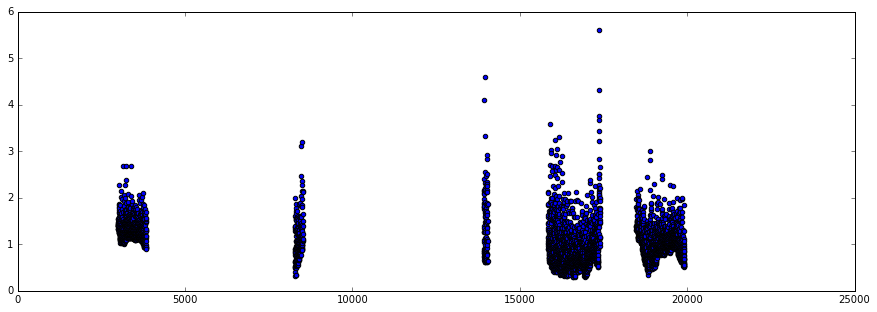

In [17]:
# plot
fig = plt.figure(figsize=(15,5))
# plot_temp = dfs_trunc[dfs_trunc['affprop_d99']==24]
# plt.scatter(plot_temp.index,plot_temp['d_temp'])
plot_temp1 = dfs_trunc[dfs_trunc['affprop']==14]
plt.scatter(plot_temp1.index,plot_temp1['vect_2norm']);

In [18]:
i=14
temp_results = results[results['affprop']==i].values[:,:-2]

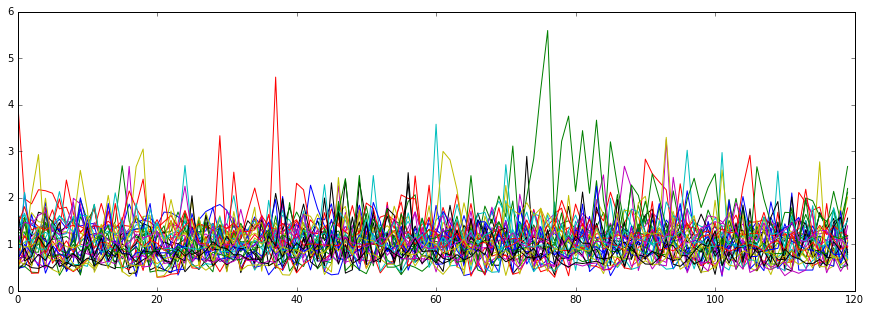

In [19]:
fig = plt.figure(figsize=(15,5))
for i in temp_results:
    plt.plot(i)

## Now predict each class....

In [49]:
def rollin(data, stopper):
    # train
    train = dfs_trunc[:stopper]
    X = train.drop(['affprop','affprop_d99','vect_2norm'],axis=1).values
    y = train['affprop'].values

    # test
    test = dfs_trunc[stopper:stopper+1]
    X_test = test.drop(['affprop','affprop_d99','vect_2norm'],axis=1).values
    y_test = test['affprop'].values
    
    return X,y,X_test,y_test

In [75]:
predict_list = []
for i in range(4000,4500):
    results = rollin(dfs_trunc,i)
    model = svm.SVC(C=1.0)
    model.fit(results[0],results[1])
    
    predict_list.append(model.predict(results[2])[0])
    

In [76]:
run1 = dfs_trunc[4000:4500].copy()

In [77]:
run1['svc'] = predict_list

In [79]:
run1

,temp,pressure,humidity,d_temp,d_humidity,d_pressure,vect_2norm,affprop,affprop_d99,svc
4000,1.561301,-0.729604,-1.249993,0.062661,0.011812,-0.425048,2.171911,11,4,11
4001,1.570220,-0.731358,-1.253348,0.434082,-0.084670,-0.303653,2.204350,11,4,11
4002,1.574685,-0.736010,-1.260647,0.216375,-0.185091,-0.812238,2.313306,11,4,11
4003,1.589159,-0.731199,-1.266475,0.705644,-0.147613,0.848131,2.429627,11,4,11
4004,1.596340,-0.732327,-1.272255,0.349120,-0.146427,-0.193682,2.209995,11,4,11
4005,1.601965,-0.730681,-1.285594,0.273028,-0.338843,0.292733,2.242318,11,4,11
4006,1.603869,-0.735183,-1.280376,0.091143,0.133592,-0.785714,2.322876,11,4,11
4007,1.608132,-0.731322,-1.286447,0.206473,-0.153806,0.681390,2.303572,11,4,11
4008,1.613653,-0.736065,-1.289942,0.268002,-0.088236,-0.827967,2.361093,11,4,11
4009,1.623375,-0.729129,-1.301746,0.473299,-0.299782,1.220965,2.581889,11,4,11
